### Import required libraries

In [1]:
import pandas as pd
import numpy as np
from math import floor
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from time import time
from sklearn.metrics import accuracy_score, f1_score, classification_report
import re
import nltk
from nltk.tokenize import word_tokenize,sent_tokenize
#import gensim
import time

from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.models import Sequential
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


You are given the reviews dataset. These are 194439 amazon reviews for cell phones and accessories taken from https://jmcauley.ucsd.edu/data/amazon/ Use the “reviewText” and “overall” fields from this file. The goal is to predict the rating given the review by modeling it as a multi-class classification problem.

In [2]:
data = pd.read_json("Cell_Phones_and_Accessories_5.json", lines=True)

In [3]:
data.shape

(194439, 9)

The dataset has 194439 rows and 9 columns

In [4]:
data.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A30TL5EWN6DFXT,120401325X,christina,"[0, 0]",They look good and stick good! I just don't li...,4,Looks Good,1400630400,"05 21, 2014"
1,ASY55RVNIL0UD,120401325X,emily l.,"[0, 0]",These stickers work like the review says they ...,5,Really great product.,1389657600,"01 14, 2014"
2,A2TMXE2AFO7ONB,120401325X,Erica,"[0, 0]",These are awesome and make my phone look so st...,5,LOVE LOVE LOVE,1403740800,"06 26, 2014"
3,AWJ0WZQYMYFQ4,120401325X,JM,"[4, 4]",Item arrived in great time and was in perfect ...,4,Cute!,1382313600,"10 21, 2013"
4,ATX7CZYFXI1KW,120401325X,patrice m rogoza,"[2, 3]","awesome! stays on, and looks great. can be use...",5,leopard home button sticker for iphone 4s,1359849600,"02 3, 2013"


### Use the “reviewText” and “overall” fields from this file

In [5]:
data['reviewText'] = data['reviewText'] + data['summary'] 

In [6]:
data = data[['reviewText', 'overall']]

In [7]:
data.head()

,reviewText,overall
0,They look good and stick good! I just don't li...,4
1,These stickers work like the review says they ...,5
2,These are awesome and make my phone look so st...,5
3,Item arrived in great time and was in perfect ...,4
4,"awesome! stays on, and looks great. can be use...",5


In [8]:
data.overall.value_counts()

5    108664
4     39993
3     21439
1     13279
2     11064
Name: overall, dtype: int64

In [9]:
validate = data[floor(0.7*len(data)):floor(0.8*len(data))]
test = data[floor(0.8*len(data)):]

data = data[0:floor(0.7*len(data))]

print(data.shape, validate.shape, test.shape)

(136107, 2) (19444, 2) (38888, 2)


In [15]:
#I do aspire here to have balanced classes
num_of_categories = 17000
shuffled = data.reindex(np.random.permutation(data.index))
a = shuffled[shuffled['overall'] == 1][:num_of_categories]
b = shuffled[shuffled['overall'] == 2][:num_of_categories]
c = shuffled[shuffled['overall'] == 3][:num_of_categories]
d = shuffled[shuffled['overall'] == 4][:num_of_categories]
e = shuffled[shuffled['overall'] == 5][:num_of_categories]
concated = pd.concat([a,b,c,d,e], ignore_index=True)
#Shuffle the dataset
concated = concated.reindex(np.random.permutation(concated.index))
concated['label'] = 0

In [19]:
#One-hot encode the lab
concated.loc[concated['overall'] == 1, 'label'] = 1
concated.loc[concated['overall'] == 2, 'label'] = 2
concated.loc[concated['overall'] == 3, 'label'] = 3
concated.loc[concated['overall'] == 4, 'label'] = 4
concated.loc[concated['overall'] == 5, 'label'] = 0
print(concated['label'][:10])
labels = to_categorical(concated['label'], num_classes=5)
print(labels[:10])
if 'overall' in concated.keys():
    concated.drop(['overall'], axis=1)

62317    0
54785    0
34194    3
21926    3
40135    4
45315    4
52678    0
21632    3
13570    2
20405    3
Name: label, dtype: int64
[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]]


In [20]:
print(concated.overall.value_counts())
print(concated.label.value_counts())

5    17000
4    17000
3    15843
1    10141
2     8226
Name: overall, dtype: int64
4    17000
0    17000
3    15843
1    10141
2     8226
Name: label, dtype: int64


In [22]:
concated

,reviewText,overall,label
62317,Ok so I've been using this battery daily for o...,5,0
54785,I am very pleased with the whole line of Jabra...,5,0
34194,Overall happy with the product. I've bought se...,3,3
21926,I think the looks and comfort of this headset ...,3,3
40135,I don't like using hands free devices. I don't...,4,4
...,...,...,...
30580,I do not really like it. I looked old. It was ...,3,3
43994,"The case fits nice, but you have to make sure ...",4,4
16740,I'm not very impressed with this. It's super ...,2,2
52484,"When I first opened the Mountek package, I was...",5,0


In [23]:
n_most_common_words = 8000
max_len = 130
tokenizer = Tokenizer(num_words=n_most_common_words, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(concated['reviewText'].values)
sequences = tokenizer.texts_to_sequences(concated['reviewText'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

X = pad_sequences(sequences, maxlen=max_len)

Found 58916 unique tokens.


In [24]:
X_train, X_test, y_train, y_test = train_test_split(X , labels, test_size=0.25, random_state=42)

In [25]:
epochs = 10
emb_dim = 128
batch_size = 256
labels[:2]

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32)

In [27]:
print((X_train.shape, y_train.shape, X_test.shape, y_test.shape))

model = Sequential()
model.add(Embedding(n_most_common_words, emb_dim, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.7))
model.add(LSTM(64, dropout=0.7, recurrent_dropout=0.7))
model.add(Dense(5, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
print(model.summary())
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',patience=7, min_delta=0.0001)])

((51157, 130), (51157, 5), (17053, 130), (17053, 5))
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 130, 128)          1024000   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 130, 128)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 325       
Total params: 1,073,733
Trainable params: 1,073,733
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\akhil\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 40925 samples, validate on 10232 samples
Epoch 1/10
40925/40925 [==============================] - 52s 1ms/step - loss: 1.5092 - acc: 0.3170 - val_loss: 1.3037 - val_acc: 0.4675
Epoch 2/10
40925/40925 [==============================] - 53s 1ms/step - loss: 1.2608 - acc: 0.4563 - val_loss: 1.1493 - val_acc: 0.5140
Epoch 3/10
40925/40925 [==============================] - 53s 1ms/step - loss: 1.1927 - acc: 0.4885 - val_loss: 1.1224 - val_acc: 0.5193
Epoch 4/10
40925/40925 [==============================] - 53s 1ms/step - loss: 1.1603 - acc: 0.4992 - val_loss: 1.1161 - val_acc: 0.5216
Epoch 5/10
40925/40925 [==============================] - 54s 1ms/step - loss: 1.1362 - acc: 0.5128 - val_loss: 1.1050 - val_acc: 0.5310
Epoch 6/10
40925/40925 [==============================] - 58s 1ms/step - loss: 1.1231 - acc: 0.5191 - val_loss: 1.0941 - val_acc: 0.5331
Epoch 7/10
40925/40925 [==============================] - 58s 1ms/step - loss: 1.1061 - acc: 0.5272 - val_loss: 1.0952 - val_acc

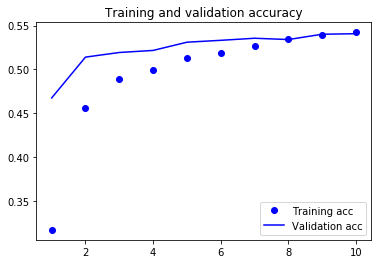

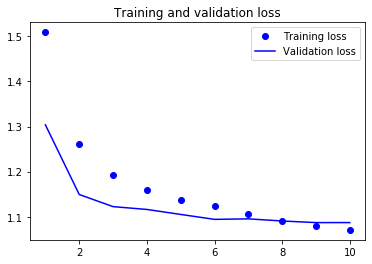

In [29]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [33]:
X_train.shape

(51157, 130)

In [39]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [40]:
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
from keras.utils import to_categorical

# Define your model
model = Sequential()
model.add(SimpleRNN(units=100, input_shape=(51157, 130)))
model.add(Dense(5, activation='softmax'))

# Compile your model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train your model
history = model.fit(X_train, y_train, epochs=10, batch_size=32)

# Evaluate your model
score = model.evaluate(X_test, y_test, batch_size=32)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

ValueError: Error when checking input: expected simple_rnn_6_input to have shape (51157, 130) but got array with shape (130, 1)